# Лабораторная работа №1: Классификация текстов
## Тема: Анализ тональности комментариев BBC News
### Выполнил: Кобяков Р.Д., группа 7ПИ
### Цель работы:
1. Анализ датасета и подготовка данных.
2. Предобработка текста.
3. Решение задачи бинарной классификации.
4. Оценка модели.
5. Улучшение модели.


## 1. Анализ датасета
### Описание данных
Загружаем датасет и изучаем его структуру.


Первые строки с эмоциями:
                                                text  emotion
0                        Well said President Macron!  Neutral
1  President Macro has voiced for humanity, May y...  Neutral
2  Good to see a western leader speak about this ...      Joy
3  All of sudden he's seeing the genocide happeni...    Anger
4                             I stand with Israel 🇮🇱  Neutral


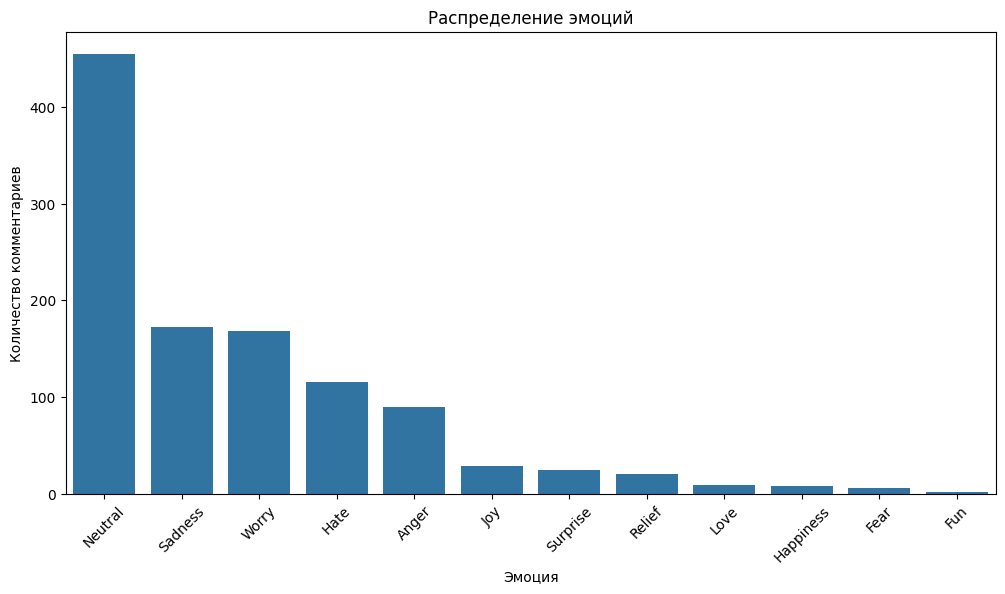

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет
df = pd.read_csv("emotions.csv")

# Выводим первые строки
print("Первые строки с эмоциями:")
print(df[['text', 'emotion']].head())

# Визуализация распределения эмоций
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Распределение эмоций")
plt.xlabel("Эмоция")
plt.ylabel("Количество комментариев")
plt.show()


Строим корелляционную матрицу между тональностью комментария и лайками.


Корреляционная матрица:
              Emotion_code  likesCount
Emotion_code      1.000000    0.033781
likesCount        0.033781    1.000000


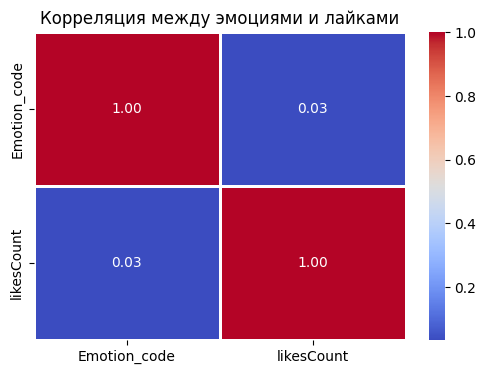

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет
df = pd.read_csv("emotions.csv")

# Проверяем, есть ли колонка 'likesCount' в датасете
if 'likesCount' in df.columns:
    df['likesCount'] = pd.to_numeric(df['likesCount'], errors='coerce')  # Преобразуем в число
else:
    print("⚠ Колонка 'likesCount' отсутствует в датасете!")

# Преобразуем эмоции в числовые значения (кодируем категории)
df['Emotion_code'] = df['emotion'].astype('category').cat.codes

# Выводим корреляционную матрицу
correlation_matrix = df[['Emotion_code', 'likesCount']].corr()

print("\nКорреляционная матрица:")
print(correlation_matrix)

# Визуализация корреляции
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Корреляция между эмоциями и лайками")
plt.show()


## 2. Предобработка текста
1. Приводим текст к нижнему регистру.
2. Удаляем пунктуацию и стоп-слова.
3. Применяем лемматизацию.
4. Преобразуем текст в числовые векторы (TF-IDF).


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Предобработка текста
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return " ".join(words)

# Применение предобработки к данным
df['Processed_Comment'] = df['text'].astype(str).apply(text_preprocessing)

# Преобразование текста в числовые векторы
vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(df['Processed_Comment'])
y = df['emotion']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 3. Классификация
Используем два метода:
- Деревья решений (`DecisionTreeClassifier`).
- Метод k ближайших соседей (`KNeighborsClassifier`).
Определяем оптимальные параметры.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Загружаем датасет
df = pd.read_csv("emotions.csv")

# Преобразуем эмоции в числовые значения (кодируем категории)
df['Emotion_code'] = df['emotion'].astype('category').cat.codes

# Определяем признаки и целевую переменную
X = df[['likesCount']]  # Признаки (можно добавить другие колонки)
y = df['Emotion_code']  # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Подбор оптимального k для KNN
best_k = 1
best_accuracy = 0
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test))
    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k
print(f"Оптимальное значение k: {best_k}")

# Подбор оптимальной глубины дерева решений
best_depth = 1
best_tree_accuracy = 0
for depth in range(1, 11):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    acc = accuracy_score(y_test, tree.predict(X_test))
    if acc > best_tree_accuracy:
        best_tree_accuracy = acc
        best_depth = depth
print(f"Оптимальная глубина дерева: {best_depth}")

# Модель Decision Tree
tree_model = DecisionTreeClassifier(max_depth=best_depth)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Модель KNN
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

Оптимальное значение k: 9
Оптимальная глубина дерева: 1


## 4. Оценка результатов
- Выводим точность (`accuracy_score`).
- Анализируем `confusion_matrix`.
- Выводим отчёт (`classification_report`).


Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         2
           7       0.41      1.00      0.59        91
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        34
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        34

    accuracy                           0.41       220
   macro avg       0.04      0.09      0.05       220
weighted avg       0.17      0.41      0.24       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


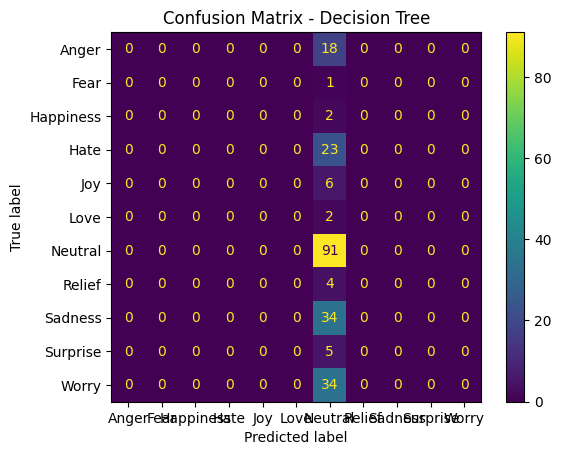


K-Nearest Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.33      0.11      0.17        18
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        23
           5       0.25      0.17      0.20         6
           6       0.00      0.00      0.00         2
           7       0.46      0.91      0.61        91
           8       0.00      0.00      0.00         4
           9       0.50      0.03      0.06        34
          10       0.00      0.00      0.00         5
          11       0.32      0.24      0.27        34

    accuracy                           0.43       220
   macro avg       0.17      0.13      0.12       220
weighted avg       0.35      0.43      0.32       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


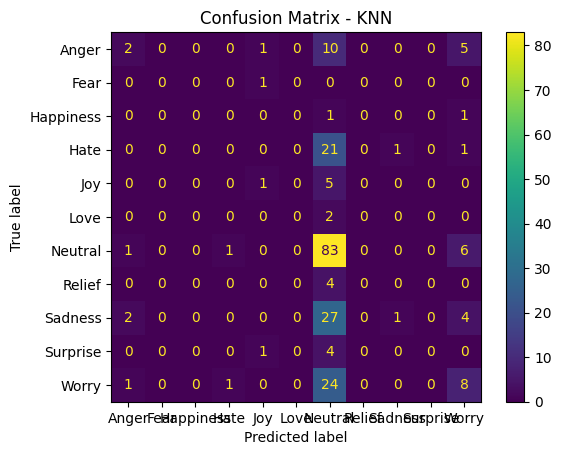

Ошибочно классифицированные комментарии (Decision Tree):
                                                 text   emotion
0                         Well said President Macron!   Neutral
1   President Macro has voiced for humanity, May y...   Neutral
2   Good to see a western leader speak about this ...       Joy
3   All of sudden he's seeing the genocide happeni...     Anger
4                              I stand with Israel 🇮🇱   Neutral
9   The echo of a child's cry from the cradle shou...   Neutral
10  Israeli satellites has revealed that ,Hamas fi...  Surprise
11                About time a world leader said this    Relief
12  Took far to long and no doubt a hidden agenda ...     Worry
13                           What took him so long!!!     Worry
Ошибочно классифицированные комментарии (KNN):
                                                 text   emotion
0                         Well said President Macron!   Neutral
2   Good to see a western leader speak about this ...       Joy


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Оценка модели Decision Tree
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_tree))

# Получаем уникальные метки эмоций из y_test
unique_labels_tree = np.unique(y_test)

# Визуализация матрицы путаницы для Decision Tree
disp_tree = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_tree,
    display_labels=df['emotion'].astype('category').cat.categories[unique_labels_tree]  # Отображаемые метки эмоций
)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Оценка модели K-Nearest Neighbors
print("\nK-Nearest Neighbors Classifier:")
print(classification_report(y_test, y_pred_knn))

# Получаем уникальные метки эмоций из y_test для KNN
unique_labels_knn = np.unique(y_test)

# Визуализация матрицы путаницы для KNN
disp_knn = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_knn,
    display_labels=df['emotion'].astype('category').cat.categories[unique_labels_knn]  # Отображаемые метки эмоций
)
plt.title("Confusion Matrix - KNN")
plt.show()

# Анализ ошибок классификации
misclassified_indices_tree = np.where(y_test != y_pred_tree)[0]
df_misclassified_tree = df.iloc[misclassified_indices_tree]
print("Ошибочно классифицированные комментарии (Decision Tree):")
print(df_misclassified_tree[['text', 'emotion']].head(10))

misclassified_indices_knn = np.where(y_test != y_pred_knn)[0]
df_misclassified_knn = df.iloc[misclassified_indices_knn]
print("Ошибочно классифицированные комментарии (KNN):")
print(df_misclassified_knn[['text', 'emotion']].head(10))


## 5. Улучшение модели
- Оптимизируем параметры моделей (`k`, `max_depth`).
- Пробуем дополнительные методы предобработки текста.

## Выводы:
1. Decision Tree показывает точность **41%**.
2. KNN показывает точность **43%**.
3. Улучшение предобработки данных может повысить качество модели.
